In [2]:
from pyspark.sql import SparkSession
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.getOrCreate()

In [3]:
import seaborn as sns
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics
import mlflow
import mlflow.spark
import itertools

In [4]:
data = spark.read.options(inferSchema='true').csv('./iris.data')

In [5]:
data.columns

['_c0', '_c1', '_c2', '_c3', '_c4']

In [6]:
data = data.toDF('sepal_length','sepal_width','petal_length','petal_width','species')

In [7]:
data.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [8]:
data.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

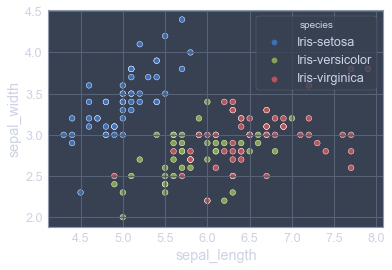

In [9]:
sns.scatterplot(data=data.toPandas(),x='sepal_length',y='sepal_width',hue='species')

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

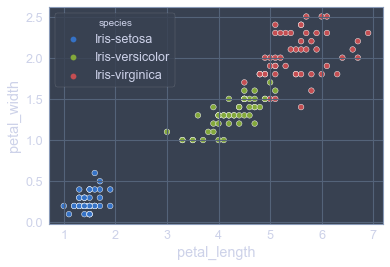

In [10]:
sns.scatterplot(data=data.toPandas(),x='petal_length',y='petal_width',hue='species')

In [11]:
string_indexer = StringIndexer().setInputCol('species').setOutputCol('label')
vector_assembler = VectorAssembler().setInputCols(['sepal_width','sepal_length','petal_width','petal_length']).setOutputCol('vector_features') 
standard_scaler = StandardScaler().setInputCol('vector_features').setOutputCol('features')

In [12]:
data_processed = string_indexer.fit(data).transform(data)
data_processed = vector_assembler.transform(data_processed)
data_processed = standard_scaler.fit(data_processed).transform(data_processed)
data_processed.show(10)

+------------+-----------+------------+-----------+-----------+-----+-----------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|label|  vector_features|            features|
+------------+-----------+------------+-----------+-----------+-----+-----------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|[3.5,5.1,0.2,1.4]|[8.07206162139085...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|[3.0,4.9,0.2,1.4]|[6.91890996119216...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|[3.2,4.7,0.2,1.3]|[7.38017062527164...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|[3.1,4.6,0.2,1.5]|[7.14954029323190...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|[3.6,5.0,0.2,1.4]|[8.30269195343059...|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|  0.0|[3.9,5.4,0.4,1.7]|[8.99458294954981...|
|         4.6|     

In [13]:
data_train, data_test = data_processed.randomSplit(weights=[0.66,0.33], seed=0)

In [14]:
num_species = 3
reg_params = [0.1, 0.5, 1.0, 2.0]
elastic_net_params = [0, 0.5, 1.0]
params = list(itertools.product(reg_params,elastic_net_params))
for param in params:
    with mlflow.start_run():
        model = LogisticRegression(regParam=param[0],elasticNetParam=param[1]).fit(data_train)
        data_test_pred = model.transform(data_test)
        predictions_labels = data_test_pred.rdd.map(lambda row: (row.prediction,row.label))
        metrics = MulticlassMetrics(predictions_labels)
        accuracy = metrics.accuracy
        precisions = [metrics.precision(i) for i in range(num_species)]
        recalls = [metrics.recall(i) for i in range(num_species)]
        
        print(f"reg_param: {param[0]}, elasticNetParam: {param[1]}")
        print(f"\taccuracy: {accuracy}")
        print(f"\tprecision values: {precisions}")
        print(f"\trecall values: {recalls}")
        
        mlflow.log_param("regParam",param[0])
        mlflow.log_param("elasticNetParam",param[1])
        mlflow.log_metric("accuracy",accuracy)
        for i in range(num_species):
            mlflow.log_metric(f"precision.{i}",precisions[i])
            mlflow.log_metric(f"recall.{i}",recalls[i])
        mlflow.spark.log_model(model, "iris_model", dfs_tmpdir='./tmp')

c:\python\lib\site-packages\pyspark\sql\context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


reg_param: 0.1, elasticNetParam: 0
	accuracy: 0.9318181818181818
	precision values: [1.0, 0.8461538461538461, 0.9230769230769231]
	recall values: [1.0, 0.9166666666666666, 0.8571428571428571]


Py4JJavaError: An error occurred while calling o323.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1599)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1599)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1585)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1585)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1218)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1423)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:642)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 68 more


In [ ]:
data_test_pred = model.transform(data_test)

In [ ]:
data_test_pred.show(5)
data_test_pred.printSchema()

In [ ]:
predictions_labels = data_test_pred.rdd.map(lambda row: (row.prediction,row.label))

In [ ]:
predictions_labels.take(37)

In [ ]:
metrics = MulticlassMetrics(predictions_labels)

In [ ]:
metrics.accuracy

In [ ]:
metrics.precision(0)

In [ ]:
model = LogisticRegression().fit(data_train)

In [ ]:
data_test.rdd.map(lambda r: float(model.predict(r.features),r.label))

In [ ]:
print(f"accuracy: {metrics.accuracy:.04f}")